In [1]:

suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))

# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

In [2]:
seurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0709_renew/soupX.flt_Matrix/macaque_snrna_all_soupX_unfil_batch2_0709.rds')

seurat

An object of class Seurat 
21640 features across 129748 samples within 1 assay 
Active assay: RNA (21640 features, 0 variable features)

In [3]:
table(seurat@meta.data$group)
length(unique(seurat@meta.data$group))


3064-1 3064-2 3065-1 3065-2 3066-1 3066-2 3067-1 3067-2 3068-1 3068-2 3068-3 
  7446   7310   6270   6216   7616   6869   5619   5898   6378   6897   6801 
3068-4 3068-5 3068-6 3069-1 3069-2 3069-3 3069-4 3069-5 3069-6 
  5769   6315   6353   6234   6399   6126   6295   6317   6620 

[1] 20

In [4]:
#去除 median nfeature <500
df_meta=seurat@meta.data
group_med_feature=df_meta %>% group_by(group)  %>% summarise(med=median(nFeature_RNA))
select_group=group_med_feature[group_med_feature$med > 500,]$group
#被去掉的文库
length(group_med_feature$group)
group_med_feature[group_med_feature$med < 500,]$group
length(select_group)

seurat=subset(seurat,group %in% select_group)


[1] 20

[1] "3064-1" "3064-2"

[1] 18

In [5]:
MTGenes = c("ND6","COX3","COX1","ND5","ND4","ND2","ND4L","ATP8","CYTB","COX2","ND3","ATP6","ND1")
seurat[["percent.mt"]] <- PercentageFeatureSet(seurat, features = MTGenes)



In [6]:
libMetaTb = read_xlsx(paste0(
    "/home/liuyx/liuyuxuan/spa_seurat/cla", 
    "/sample_lib_meta.xlsx"
))
libMetaTb=libMetaTb[,c('tissue','sampleID')]
colnames(libMetaTb)=c('sampleId','sampleID')
libMetaTb$libId=str_extract(libMetaTb$sampleID,'[0-9][0-9][0-9][0-9]-[0-9]')
libMetaTb$sampleID=NULL
libMetaTb=libMetaTb[!(is.na(libMetaTb$libId)),]
head(libMetaTb)

New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`


sampleId    libId 
1 Cla-rostral 6103-1
2 Cla-rostral 6103-2
3 Cla-rostral 6103-3
4 Cla-rostral 6103-4
5 Cla-rostral 6103-5
6 Cla-rostral 6103-6

In [7]:
seurat@meta.data$libId=seurat@meta.data$group

tmpMetaTb = as_tibble(seurat@meta.data[c("libId")])
tmpMetaTb$cellId = rownames(seurat@meta.data)
tmpMetaTb = left_join(tmpMetaTb, libMetaTb[c("sampleId", "libId")], by="libId")
tmpMetaTb = column_to_rownames(tmpMetaTb, var="cellId")
identical(rownames(tmpMetaTb), rownames(seurat@meta.data))
# str(tmpMetaTb)
seurat = AddMetaData(seurat, tmpMetaTb)
seurat$sampleId = factor(seurat$sampleId)
seurat$libId = factor(seurat$libId)

setdiff(libMetaTb$libId, unique(seurat$libId))
length(setdiff(libMetaTb$libId, unique(seurat$libId)))



[1] TRUE

[1] "6103-1" "6103-2" "6103-3" "6103-4" "6103-5" "6103-6" "6712-1" "6712-2"
 [9] "6712-3" "6712-4" "6708-1" "6708-2" "6708-3" "6708-4" "7220-1" "7220-2"
[17] "7221-1" "7221-2" "7222-1" "7222-2" "7223-1" "7223-2" "7224-1" "7224-2"
[25] "7230-1" "7230-2" "7231-1" "7231-2" "7231-3" "7232-1" "7232-2" "7232-3"
[33] "7248-1" "7248-2"

[1] 34

In [8]:
# Basic filtering
#修改为300
oriCellNum = ncol(seurat)
seurat$countFeatureRatio = seurat$nCount_RNA / seurat$nFeature_RNA
seurat = subset(seurat, nFeature_RNA > 300 & percent.mt < 5 & countFeatureRatio > 1.2)
cellNum1 = ncol(seurat)
cellNum1
message("Filter ratio: ", cellNum1/oriCellNum)


[1] 91959

Filter ratio: 0.79969910950327



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


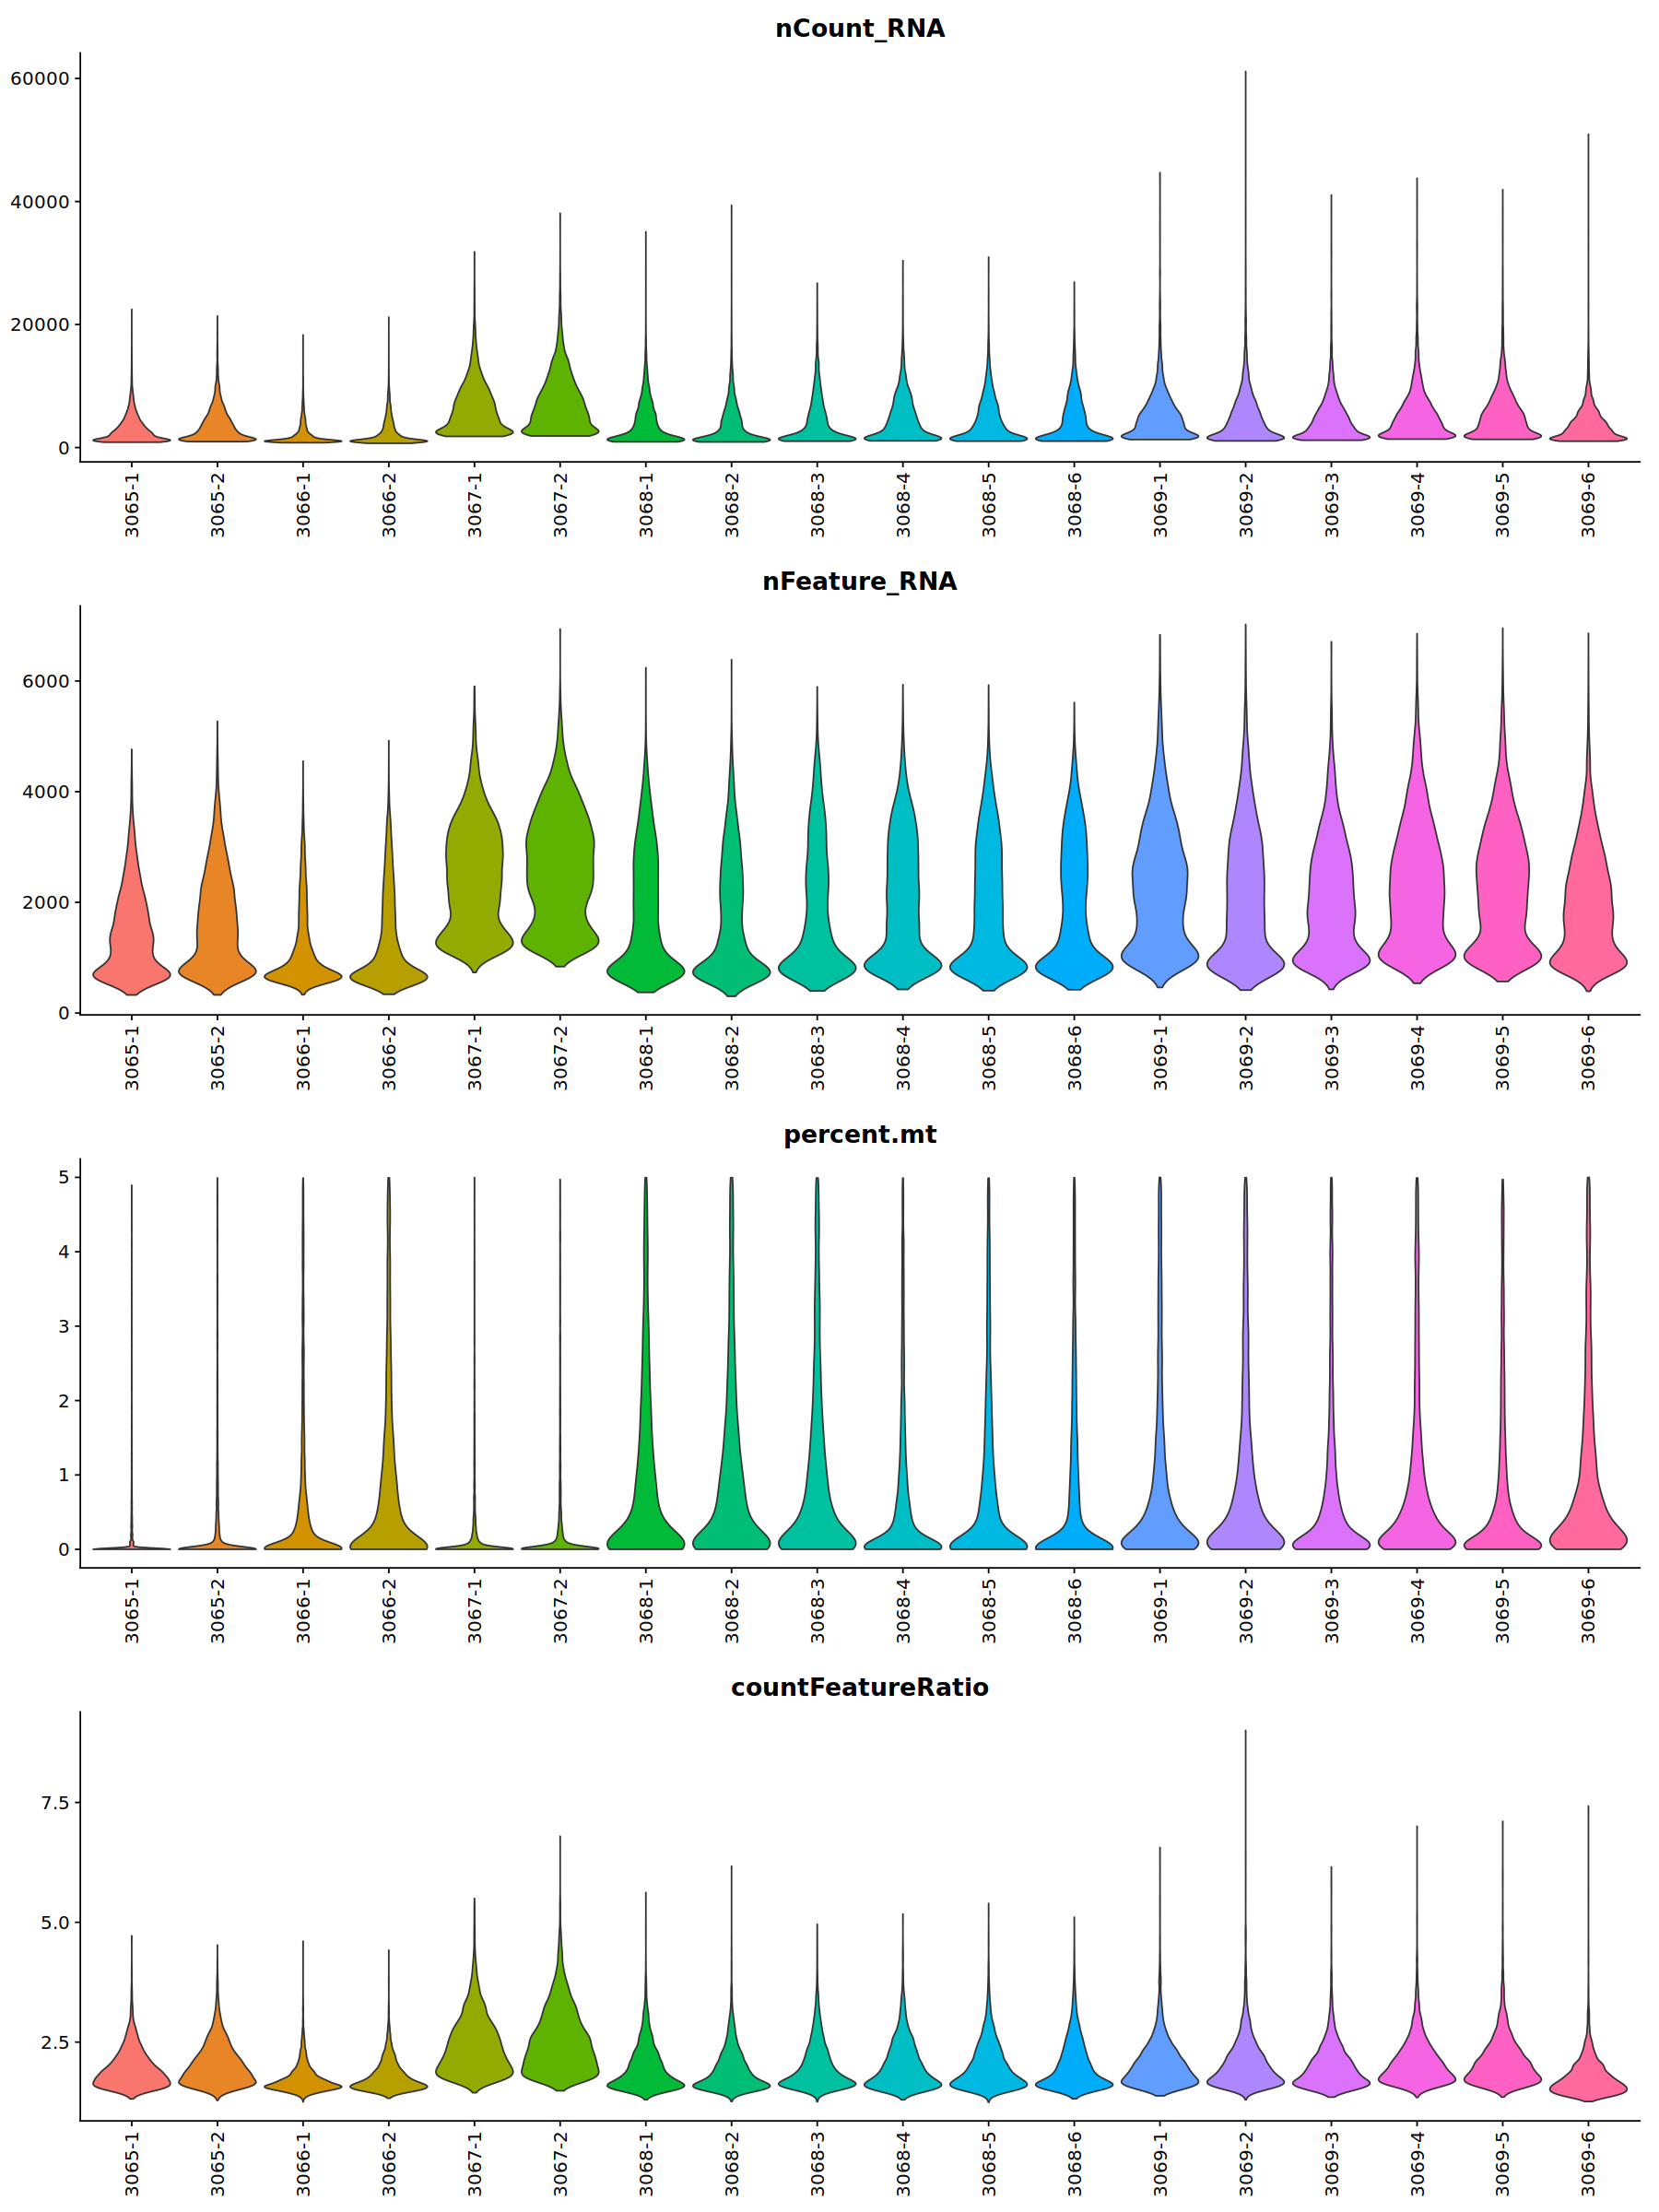

In [9]:
Idents(seurat) = "libId"
options(repr.plot.width=15, repr.plot.height=20)
print(plot_grid(
    plotlist = lapply(c("nCount_RNA", "nFeature_RNA", "percent.mt", "countFeatureRatio"), function(x) {
        p = VlnPlot(seurat, features=x, pt.size=0) + 
            theme(axis.text.x=element_text(vjust=0.5, hjust=0.5, angle=90), axis.title.x = element_blank()) +
            guides(fill=FALSE)
        return(p)
    }), 
    ncol=1, align="hv", axis="tblr"
))

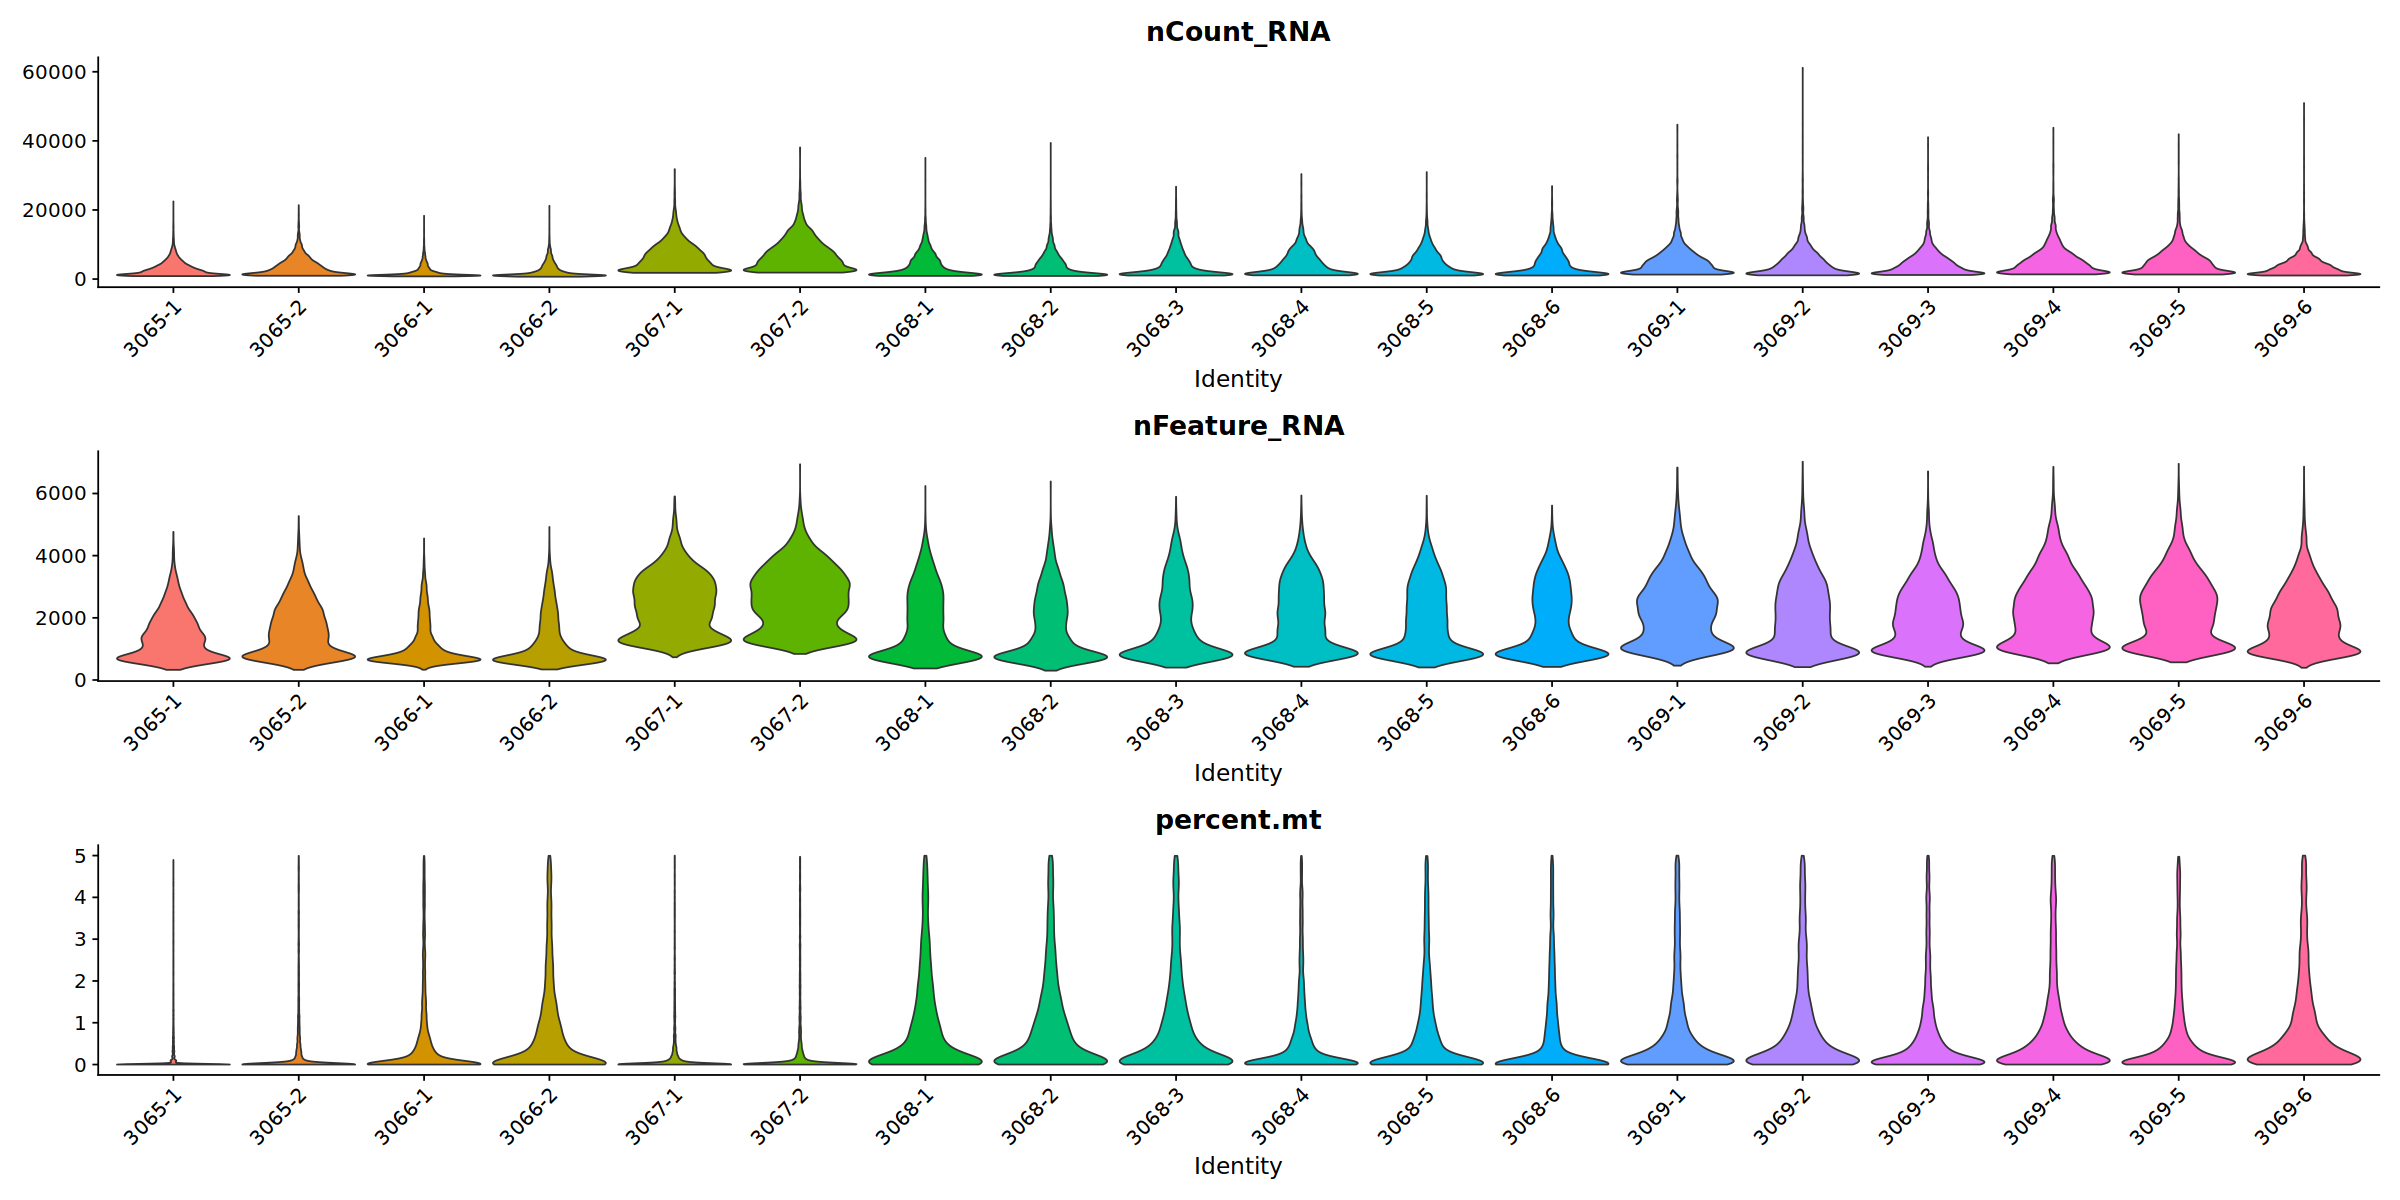

In [10]:
options(repr.plot.width=20, repr.plot.height=10)
Idents(seurat) = "group"
VlnPlot(seurat, features=c("nCount_RNA", "nFeature_RNA", "percent.mt"), pt.size=0, ncol=1)

In [11]:
#更正后mt正确版本
saveRDS(seurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0821_renew_batch3_all/batch_normalize_renew_1031/macaque_snrna_all_soupX_fil_batch2_0709_1031.rds')


In [12]:
head(seurat@meta.data)

orig.ident    nCount_RNA nFeature_RNA group  percent.mt
3065-1_CELL2351_N1 SeuratProject  6563      2603         3065-1 0.0000000 
3065-1_CELL4406_N1 SeuratProject  1317       737         3065-1 0.0000000 
3065-1_CELL99_N2   SeuratProject 12193      4073         3065-1 0.0000000 
3065-1_CELL3607_N1 SeuratProject  1821      1081         3065-1 0.1647446 
3065-1_CELL1576_N3 SeuratProject  9384      3331         3065-1 0.0000000 
3065-1_CELL5858_N1 SeuratProject   927       602         3065-1 2.2653722 
                   libId  sampleId countFeatureRatio
3065-1_CELL2351_N1 3065-1 NA       2.521322         
3065-1_CELL4406_N1 3065-1 NA       1.786974         
3065-1_CELL99_N2   3065-1 NA       2.993616         
3065-1_CELL3607_N1 3065-1 NA       1.684551         
3065-1_CELL1576_N3 3065-1 NA       2.817172         
3065-1_CELL5858_N1 3065-1 NA       1.539867

In [11]:
#原有mt不正确版本
saveRDS(seurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0709_renew/soupX.flt_Matrix/macaque_snrna_all_soupX_fil_batch2_0709.rds')




In [16]:
seurat1=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/renew_data0425/sn_rna_data/snrna_matrix_20230420/sum_data/maca/macaca_snrna_all_soupX_unfil_0425_sct.rds')
seurat1$batch='batch1'

seurat2=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0709_renew/soupX.flt_Matrix/macaque_snrna_all_soupX_fil_batch2_0709.rds')
seurat2$batch='batch2'

classFiltSeurat=merge(seurat1,seurat2)
classFiltSeurat

# Do sct together
classFiltSeurat = SCTransform(
    classFiltSeurat, assay="RNA",
    ncells=ncol(classFiltSeurat[["RNA"]]),
    variable.features.n=5000,
    vars.to.regress="percent.mt",
    return.only.var.genes = T,
    method="glmGamPoi"
)
classFiltSeurat = classFiltSeurat %>%
    RunPCA(npcs=100, verbose = FALSE) %>%
    FindNeighbors(dims = 1:50) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:50)

saveRDS(classFiltSeurat,paste0('/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0709_renew/soupX.flt_Matrix', "/macaque_snrna_batch12_soupX_fil300_SCT_0619_0524_anno_SCT.rds"))




In [ ]:
#!/bin/bash
#SBATCH -e /home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0709_renew/soupX.flt_Matrix/err
#SBATCH -o /home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0709_renew/soupX.flt_Matrix/out
#SBATCH -J 22222222222222
#SBATCH -p grande
#SBATCH -n 3
python  /home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0709_renew/soupX.flt_Matrix/sct_batch12.R


In [17]:
seurat=readRDS(paste0('/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0709_renew/soupX.flt_Matrix', "/macaque_snrna_batch12_soupX_fil300_SCT_0619_0524_anno_SCT.rds"))



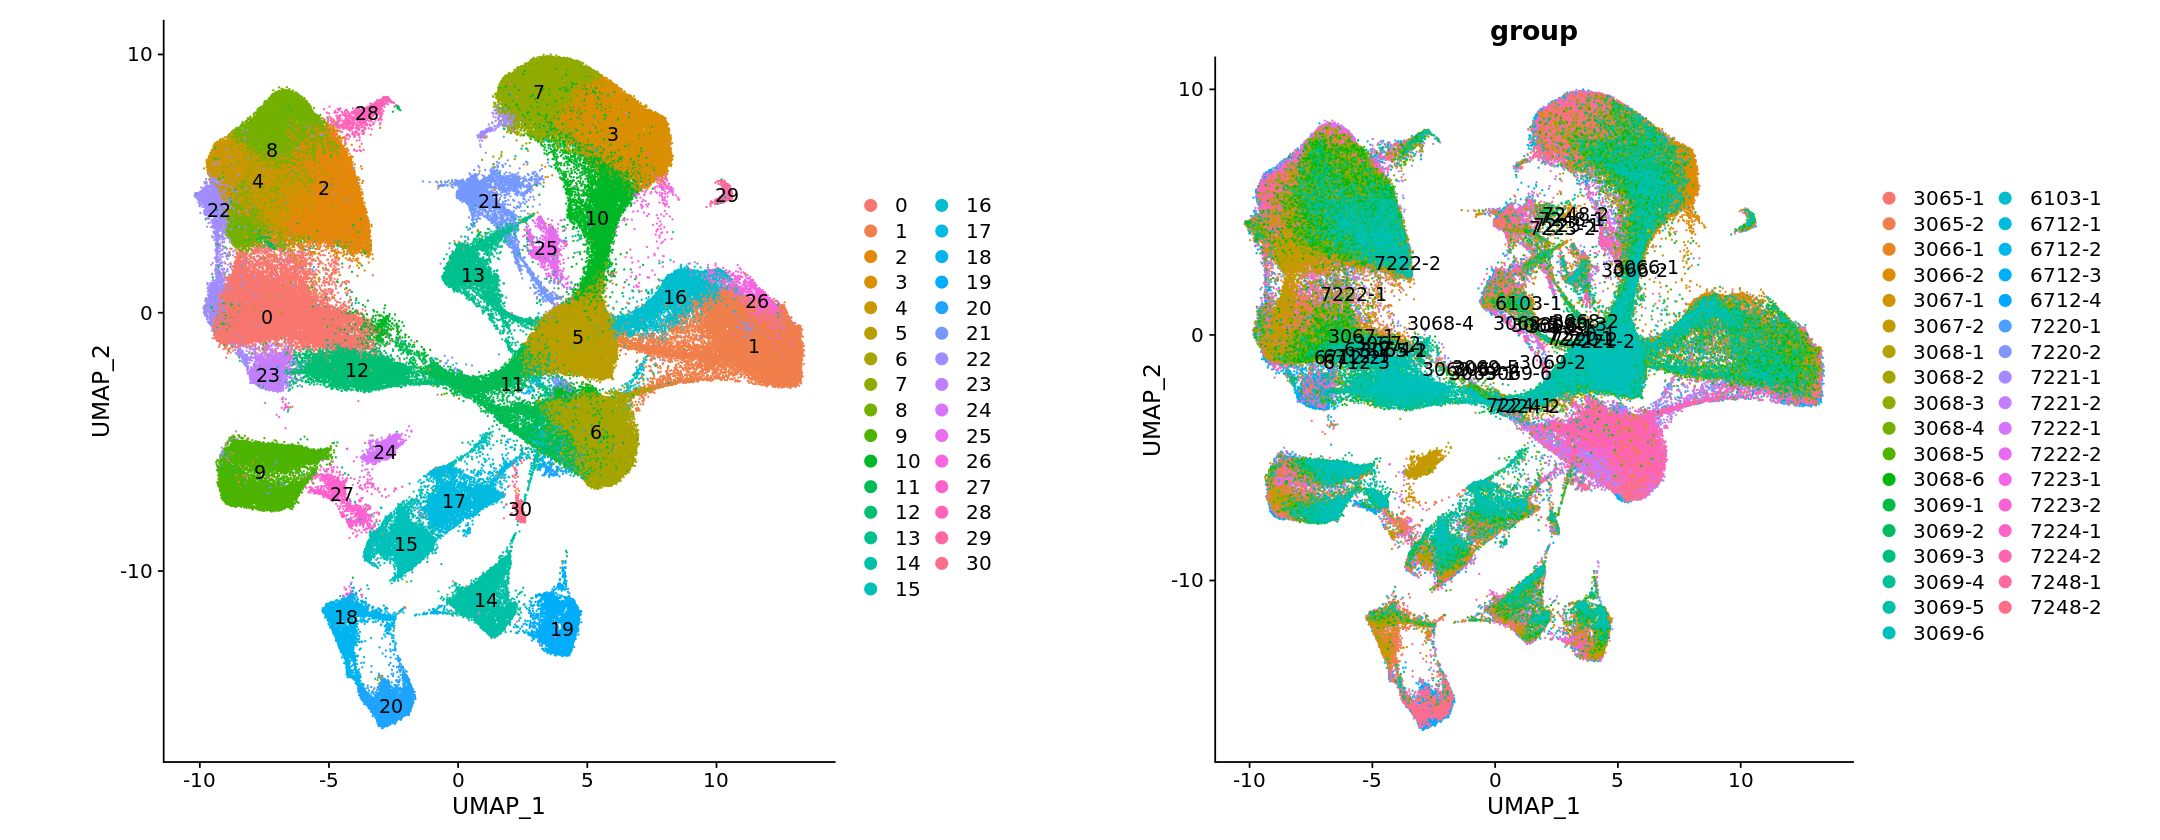

In [18]:
options(repr.plot.width=18, repr.plot.height=7)
plot_grid(
    DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed(),
    #DimPlot(seurat, reduction="umap", group.by="sampleId", label=T)+coord_fixed(),
    DimPlot(seurat, reduction="umap", group.by="group", label=T,raster=FALSE)+coord_fixed(),
    nrow=1
)

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
“The following requested variables were not found (10 out of 13 shown): DLX6-AS1, AQP4, GJA1, DNAH12, ZMYDN10, IQCG, ALPHA-SMA, PDGFRALPHA, VECAD, CD105”


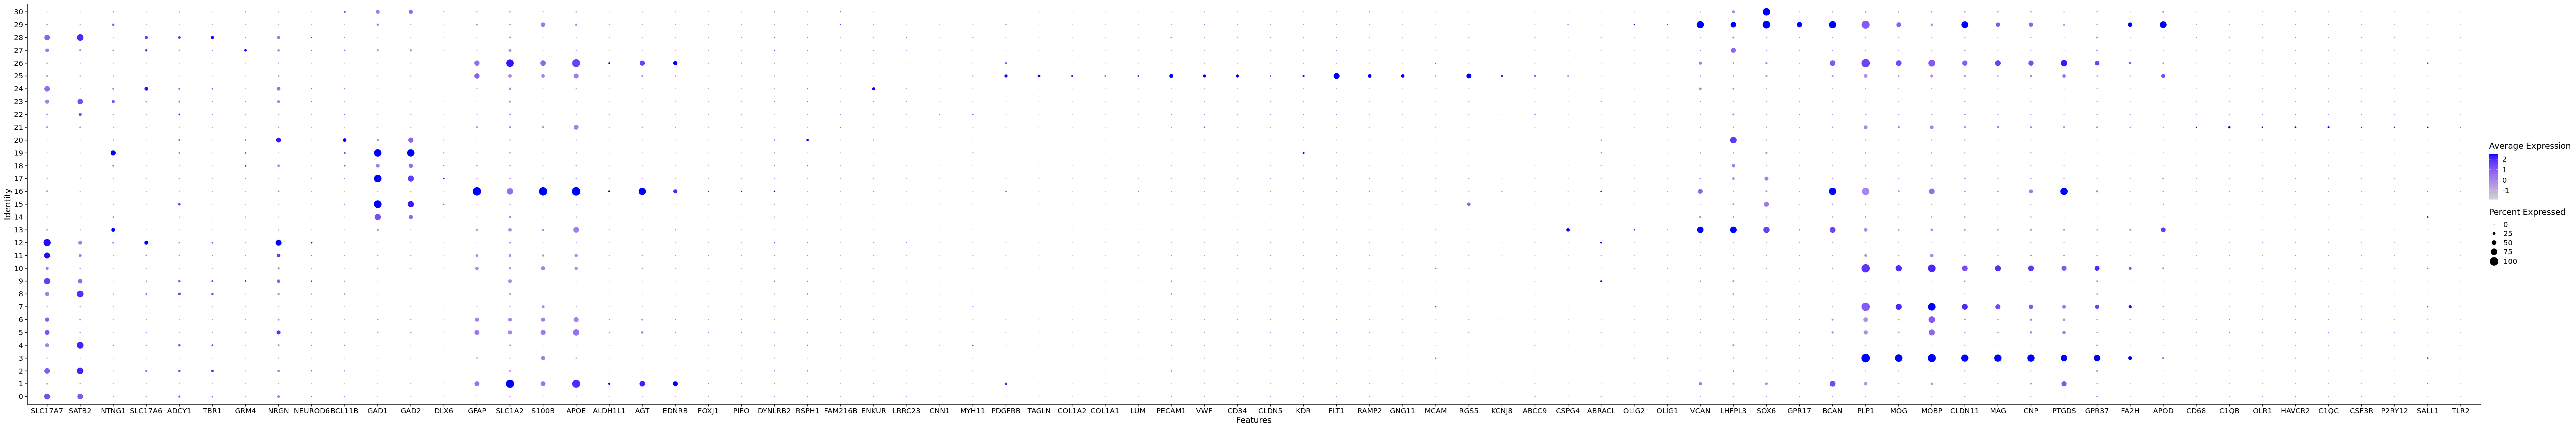

In [20]:
selectMarkers = c(
    "SLC17A7","SATB2",'NTNG1','SLC17A6','ADCY1','TBR1','GRM4','NRGN','NEUROD6','BCL11B', # Excit
    "GAD1", "GAD2",'DLX6','DLX6-AS1', # Inhib,
    "GFAP", "SLC1A2", "SLC1A2", "S100B", "AQP4", "APOE",'GJA1','ALDH1L1','AGT','EDNRB', # Astrocytes
    "FOXJ1", "PIFO", "DYNLRB2", "RSPH1", "DNAH12", "FAM216B", "ZMYDN10", "IQCG", "ENKUR","LRRC23", # Ependymal
    "CNN1", "MYH11", "PDGFRB", "TAGLN", "ALPHA-SMA", # VSMC
    "COL1A2", 'COL1A1','LUM','PDGFRALPHA',# VLMC
    "PECAM1","VWF","CD34","VECAD" ,"CLDN5","KDR","CD105",'FLT1','RAMP2','GNG11',# Endotheial
    "PDGFRB", "MCAM", "RGS5", "ALPHA-SMA", "KCNJ8",'TAGLN','COX4l2','MOTCH3','ABCC9','CSPG4', # Pericytes
    "ABRACL", "PDGFRALPHA", "OLIG2", "CSPG4", "OLIG1", "VCAN",'LHFPL3','SOX6','GPR17','BCAN', # OPC
    "PLP1",'MOG','MOBP','CLDN11','MAG','CNP','PTGDS','GPR37','FA2H','APOD', # Oligo
    'CD68','C1QB','OLR1','HAVCR2','C1QC','CSF3R','CS3CR1','P2RY12','SALL1','TLR2'# Microglia
)


selectMarkers=selectMarkers

selectMarkers=selectMarkers[!duplicated(selectMarkers)]

options(repr.plot.height=10,repr.plot.width=60)
DotPlot(seurat, features = selectMarkers)





In [28]:
seurat@meta.data$class='Uncertain'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(0,2,4,8,9,11,12,22,23,24,28),]$class='Excit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(15,17,19,14,18,20),]$class='Inhibit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(1,16,26),]$class='Astrocytes'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(3,7,10),]$class='Oligo'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(25),]$class='Endotheial'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(29,13),]$class='OPC'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(21),]$class='Microglia'


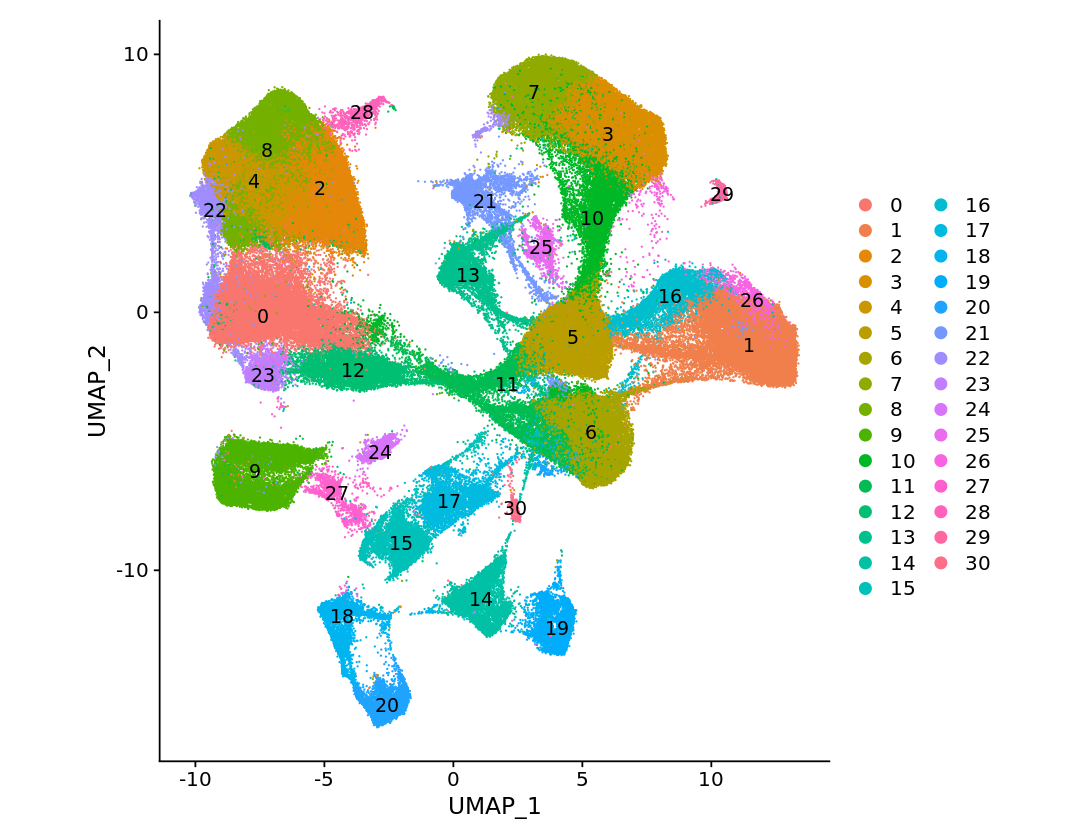

In [21]:
df_test=seurat@reductions$umap@cell.embeddings
df_test=as.data.frame(df_test)
df_test$X=rownames(df_test)

df_meta=seurat@meta.data
df_meta=as.data.frame(df_meta)
df_meta$X=rownames(df_meta)
df_meta=df_meta[,c('nFeature_RNA','X','seurat_clusters')]

df_test=left_join(df_test,df_meta,by='X')


Idents(seurat) = "seurat_clusters"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()


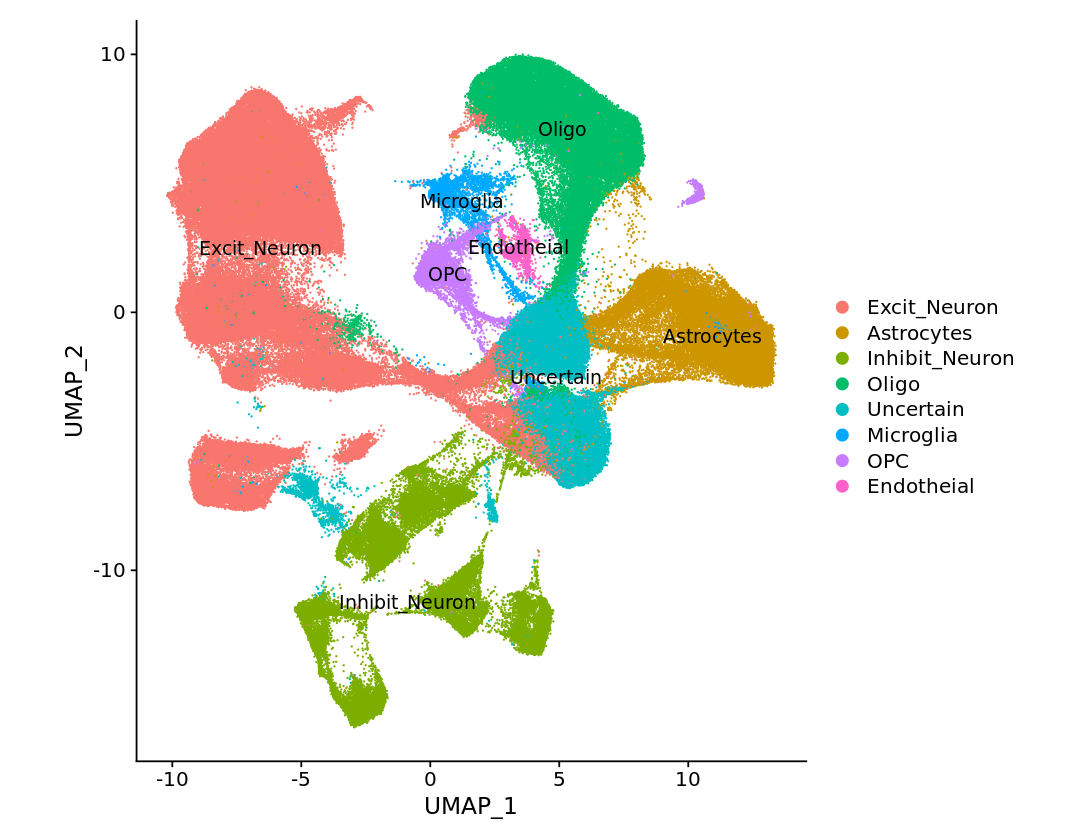

In [29]:
Idents(seurat) = "class"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()

In [30]:
# 每个class抽样80%，最多500个细胞
sampleRatio = 0.8
maxCell = 5000
sampleDf = seurat@meta.data[, c("class"), drop=F]
sampleList = split(sampleDf, sampleDf$class)
sampleList = lapply(sampleList, function(x) {
    sampleSize = as.integer(nrow(x)*0.8)
    if (sampleSize > maxCell) {
        sampleSize = maxCell
    }
    sampleIdx = 1:nrow(x)
    sampleIdx = sample(1:nrow(x), size=sampleSize, replace=F)
    return(x[sampleIdx,,drop=F])
})
sampleDf = Reduce(rbind, sampleList)
str(sampleDf)
table(sampleDf$class)

trainSeurat = seurat[,rownames(sampleDf)]
table(trainSeurat$class)

'data.frame':	34917 obs. of  1 variable:
 $ class: chr  "Astrocytes" "Astrocytes" "Astrocytes" "Astrocytes" ...



    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5000           1432           5000           5000           3485 
         Oligo            OPC      Uncertain 
          5000           5000           5000 


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5000           1432           5000           5000           3485 
         Oligo            OPC      Uncertain 
          5000           5000           5000 

In [31]:
Idents(trainSeurat) = "class"
classMarker = FindAllMarkers(trainSeurat)
#write_tsv(classMarker, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))


Calculating cluster Astrocytes

Calculating cluster Endotheial

Calculating cluster Excit_Neuron

Calculating cluster Inhibit_Neuron

Calculating cluster Microglia

Calculating cluster Oligo

Calculating cluster OPC

Calculating cluster Uncertain




    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
            49             50             36             46             46 
         Oligo            OPC      Uncertain 
            68             38             57 

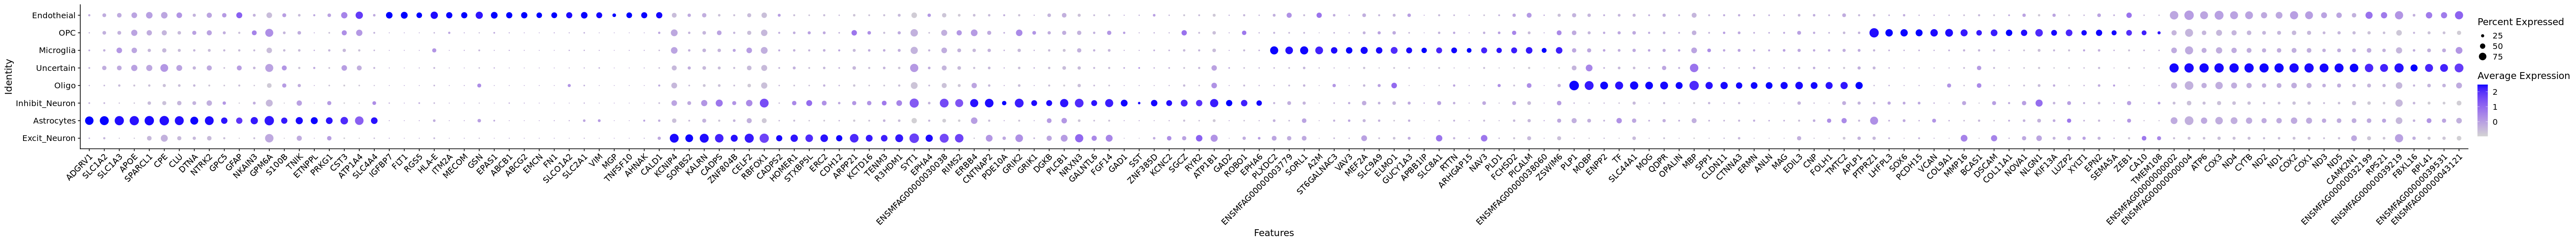

In [32]:
#classMarker = read_tsv(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))
classMarker = subset(classMarker, p_val_adj < 0.01 & avg_log2FC > 1)
table(classMarker$cluster)

classMarkerTop = classMarker %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
options(repr.plot.width=length(unique(classMarkerTop$gene))/3, repr.plot.height=5)
Idents(seurat) = "class"
DotPlot(seurat, features=unique(c(classMarkerTop$gene))) + RotatedAxis()

In [ ]:
trainDf = as.data.frame(t(as.matrix(trainSeurat[["SCT"]]@data[unique(classMarker$gene), ])))
trainDf$class = trainSeurat$class
trainDf = subset(trainDf, class != "Uncertain")
trainDf$class = factor(trainDf$class)
# We need to modify the name of the columns
colnames(trainDf) = paste0("col_", colnames(trainDf))
colnames(trainDf) = gsub("-", "_", colnames(trainDf))

rf = randomForest(col_class~., data=trainDf, ntree=500)
#saveRDS(rf, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))

 num [1:7, 1:8] 4927 49 28 18 55 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:7] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...
  ..$ : chr [1:8] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


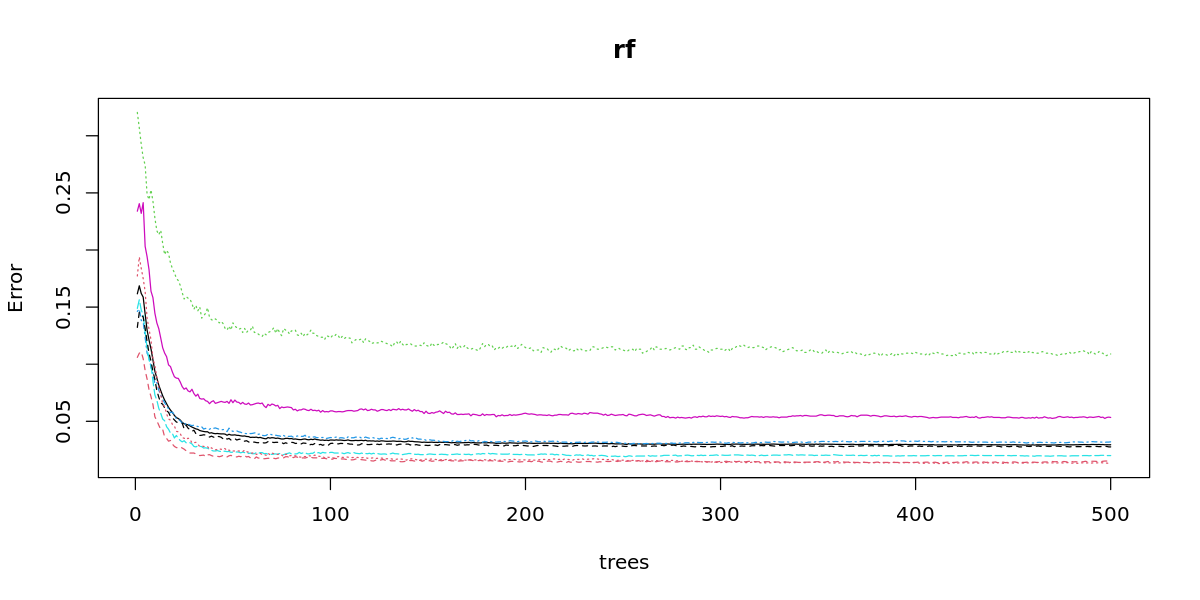

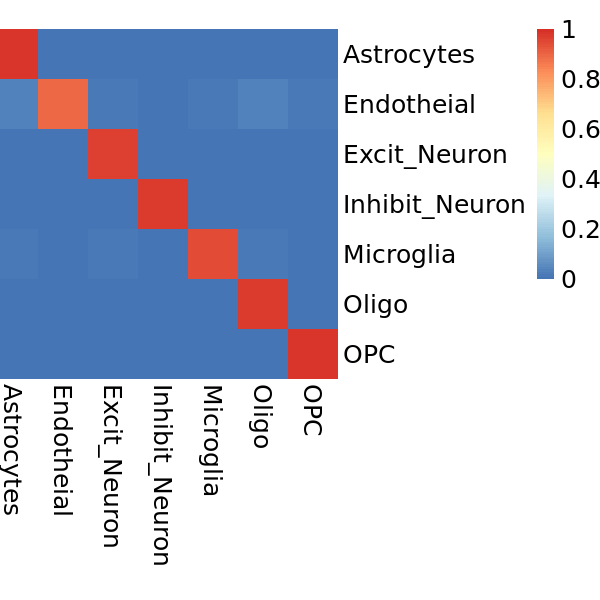

In [39]:
#rf = readRDS(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))
str(rf$confusion)
options(repr.plot.width=10, repr.plot.height=5)
plot(rf)

confusionRatio = t(apply(rf$confusion[1:7, 1:7], 1, function(x) {x/sum(x)}))
options(repr.plot.width=5, repr.plot.height=5)
pheatmap(confusionRatio, breaks=seq(0,1,0.01), cluster_rows=F, cluster_cols=F, border_color=NA, cellwidth=30, cellheight=30, fontsize=15)

 'matrix' num [1:250805, 1:7] 0 0 0.814 0 0.03 0.01 0.03 0.028 0.004 0.004 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:250805] "6103-1_CELL148_N3" "6103-1_CELL538_N2" "6103-1_CELL6244_N1" "6103-1_CELL559_N2" ...
  ..$ : chr [1:7] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


cellId             maxPredClassScore maxPredClass  
1 6103-1_CELL148_N3  0.870             Excit_Neuron  
2 6103-1_CELL538_N2  0.918             Excit_Neuron  
3 6103-1_CELL6244_N1 0.814             Astrocytes    
4 6103-1_CELL559_N2  0.880             Inhibit_Neuron
5 6103-1_CELL6281_N1 0.490             Oligo         
6 6103-1_CELL2198_N1 0.940             Excit_Neuron

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1660  0.7360  0.9140  0.8162  0.9740  1.0000 

[1] TRUE

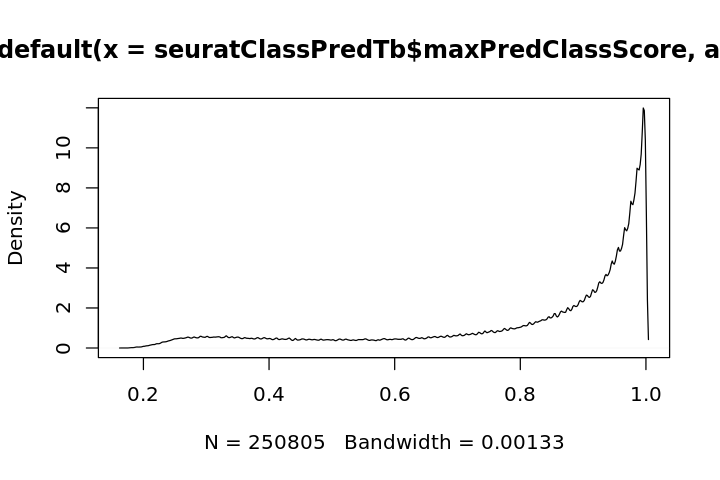

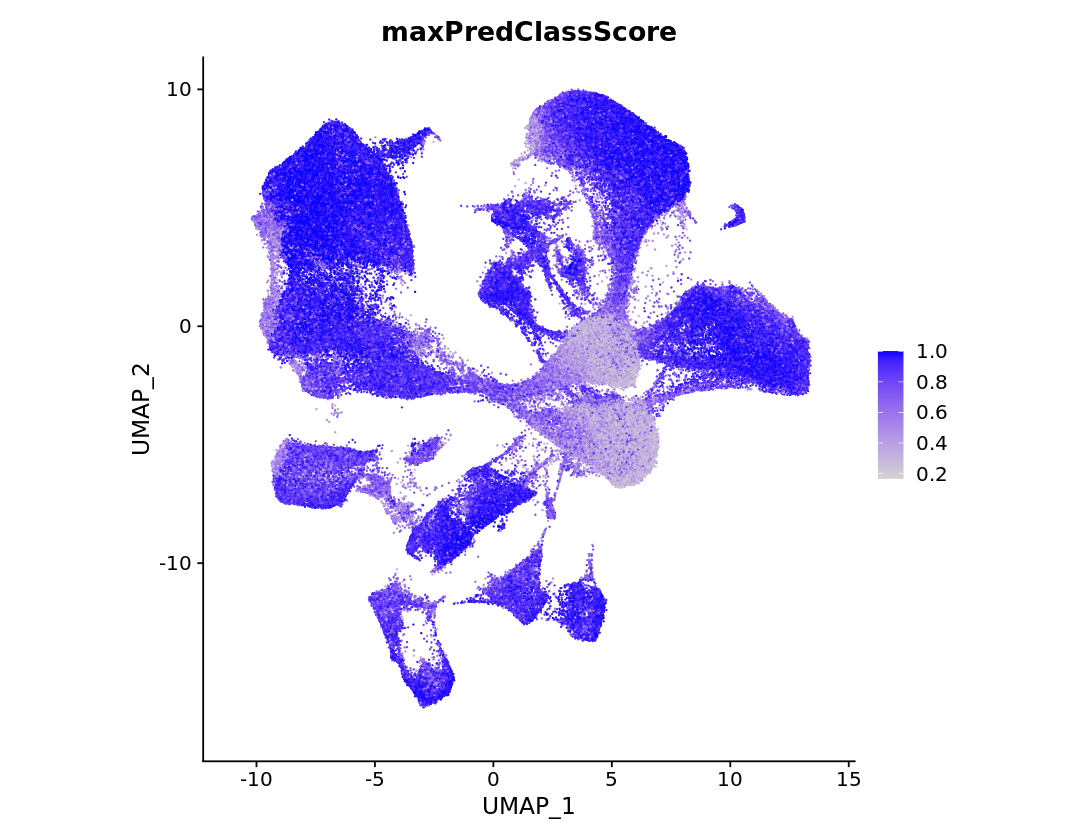

In [40]:
# Apply the trainer to filter cells
seuratCountDf = as.data.frame(t(as.matrix(seurat[["SCT"]]@data[unique(classMarker$gene), ])))
colnames(seuratCountDf) = paste0("col_", colnames(seuratCountDf))
colnames(seuratCountDf) = gsub("-", "_", colnames(seuratCountDf))
seuratClassPred = predict(rf, seuratCountDf, type="prob")
str(seuratClassPred)

seuratClassPredTb = tibble(
    cellId = rownames(seuratClassPred),
    maxPredClassScore = apply(seuratClassPred, 1, max),
    maxPredClass = apply(seuratClassPred, 1, function(x) {names(x)[which.max(x)]})
)
head(seuratClassPredTb)

summary(seuratClassPredTb$maxPredClassScore)
options(repr.plot.width=6, repr.plot.height=4)
plot(density(seuratClassPredTb$maxPredClassScore, adjust=0.1))

identical(seuratClassPredTb$cellId, rownames(seurat@meta.data))
tmpDf = as.data.frame(seuratClassPredTb[c("maxPredClassScore", "maxPredClass")])
rownames(tmpDf) = seuratClassPredTb$cellId

seurat = AddMetaData(seurat, tmpDf)

options(repr.plot.width=9, repr.plot.height=7)
FeaturePlot(seurat, reduction="umap", features="maxPredClassScore",raster=FALSE)+coord_fixed()


In [41]:
# Filter class outliers
# Removed clusters classified with ambiguous labels
# Removed cells classified with a different label from the majority of cells in its clusters
# Removed outliers when clustering, typically on the fringes of clusters in U-map space

Idents(seurat) = "seurat_clusters"
cellNum0 = ncol(seurat)
classFiltSeurat = subset(seurat, maxPredClassScore >= 0.8)
cellNum1 = ncol(classFiltSeurat)
message("Filt cell ratio: ", cellNum1/cellNum0)



Filt cell ratio: 0.695265245908176



In [42]:
seurat
classFiltSeurat

An object of class Seurat 
43040 features across 250805 samples within 2 assays 
Active assay: SCT (21153 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
43040 features across 174376 samples within 2 assays 
Active assay: SCT (21153 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [43]:
#EXIN按照nfeature800过滤
df_fil=classFiltSeurat@meta.data
EX_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Excit_Neuron',])
IN_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Inhibit_Neuron',])
Other_cell=rownames(df_fil[df_fil$maxPredClass %in% setdiff(unique(df_fil$maxPredClass),c('Excit_Neuron','Inhibit_Neuron')),])
fil_cell=c(EX_cell,IN_cell,Other_cell)

classFiltSeurat=subset(classFiltSeurat,cells = fil_cell)

classFiltSeurat


An object of class Seurat 
43040 features across 172601 samples within 2 assays 
Active assay: SCT (21153 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [44]:
saveRDS(classFiltSeurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0709_renew/soupX.flt_Matrix/macaque_snrna_batch12_soupX_fil300_800_SCT_0710_SCT.rds')




In [ ]:

suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))

options(future.globals.maxSize= 1000 * 1024^2 )

EX_resolution=0.6
IN_resolution=0.6
readDir='/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0709_renew/soupX.flt_Matrix/'
file_name='macaque_snrna_batch12_soupX_fil300_800_SCT_0710_SCT.rds'
dataDir=paste0('/home/liuyx/liuyuxuan/spa_seurat/cla/macaca/sn_0709_renew/dif_res_anno/')

classFiltSeurat=readRDS(paste0(readDir,file_name))
classFiltSeurat

#过滤nFeature<800的EX及IN
df_fil=classFiltSeurat@meta.data
EX_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Excit_Neuron',])
IN_cell=rownames(df_fil[df_fil$nFeature_RNA > 800 & df_fil$maxPredClass=='Inhibit_Neuron',])
Other_cell=rownames(df_fil[df_fil$maxPredClass %in% setdiff(unique(df_fil$maxPredClass),c('Excit_Neuron','Inhibit_Neuron')),])
fil_cell=c(EX_cell,IN_cell,Other_cell)

classFiltSeurat=subset(classFiltSeurat,cells = fil_cell)

classFiltSeurat
classFiltSeurat
table(classFiltSeurat@meta.data$maxPredClass)

Excit=subset(classFiltSeurat,maxPredClass=='Excit_Neuron')
Inhibit=subset(classFiltSeurat,maxPredClass=='Inhibit_Neuron')
pbmc=classFiltSeurat

Inhibit
all.genes <- rownames(Inhibit)
Inhibit <- ScaleData(Inhibit, features = all.genes)
Inhibit <- RunPCA(Inhibit, features = VariableFeatures(object = pbmc))
Inhibit <- FindNeighbors(Inhibit, dims = 1:15)
Inhibit <- FindClusters(Inhibit, resolution = IN_resolution)
head(Idents(Inhibit), 5)
Inhibit <- RunUMAP(Inhibit, dims = 1:15)
options(repr.plot.height=5,repr.plot.width=5)
p1=DimPlot(Inhibit, reduction = "umap")
fig_dir=paste0(dataDir,'fig/')
save_file_name=paste0(fig_dir,EX_resolution,'_res',IN_resolution,'_umap_IN.pdf')
ggsave(save_file_name,width = 5, height = 5, dpi = 100,plot = p1)



Excit
all.genes <- rownames(Excit)
Excit <- ScaleData(Excit, features = all.genes)
Excit <- RunPCA(Excit, features = VariableFeatures(object = pbmc))
Excit <- FindNeighbors(Excit, dims = 1:15)
Excit <- FindClusters(Excit, resolution = EX_resolution)
head(Idents(Excit), 5)
Excit <- RunUMAP(Excit, dims = 1:15)
options(repr.plot.height=5,repr.plot.width=5)
p1=DimPlot(Excit, reduction = "umap")
fig_dir=paste0(dataDir,'fig/')
save_file_name=paste0(fig_dir,EX_resolution,'_res',IN_resolution,'_umap_EX.pdf')
ggsave(save_file_name,width = 5, height = 5, dpi = 100,plot = p1)

Excit@meta.data$Subclass=paste0(Excit@meta.data$maxPredClass,'_',Excit@meta.data$seurat_clusters)
Inhibit@meta.data$Subclass=paste0(Inhibit@meta.data$maxPredClass,'_',Inhibit@meta.data$seurat_clusters)
sub_in=Inhibit@meta.data[,'Subclass',drop=F]
sub_ex=Excit@meta.data[,'Subclass',drop=F]
sub_2=rbind(sub_in,sub_ex)
classFiltSeurat=AddMetaData(classFiltSeurat,sub_2,col.name = 'Subclass')
classFiltSeurat@meta.data[is.na(classFiltSeurat@meta.data$Subclass),]$Subclass=classFiltSeurat@meta.data[is.na(classFiltSeurat@meta.data$Subclass),]$maxPredClass


options(repr.plot.height=12,repr.plot.width=12)
DimPlot(classFiltSeurat, label = TRUE, group.by="Subclass",raster=FALSE) + NoLegend()

p1=DimPlot(classFiltSeurat, label = TRUE, group.by="Subclass",raster=FALSE) + NoLegend()
fig_dir=paste0(dataDir,'fig/')
save_file_name=paste0(fig_dir,EX_resolution,'_res',IN_resolution,'_umap_all.pdf')
ggsave(save_file_name,width = 5, height = 5, dpi = 100,plot = p1)


save_name=gsub('.rds','',file_name)
#过滤细胞数<300的cluster
df_fil=as.data.frame(table(classFiltSeurat$Subclass))
slect_type=as.character(df_fil[df_fil$Freq > 300,]$Var1)
classFiltSeurat=subset(classFiltSeurat,Subclass %in% slect_type)

saveRDS(classFiltSeurat,paste0(dataDir, "/",save_name,EX_resolution,"_res",IN_resolution,".rds"))

classFiltSeurat
table(classFiltSeurat$Subclass)

# 每个class抽样80%，最多3000个细胞
seurat=classFiltSeurat
sampleRatio = 0.8
maxCell = 3000
sampleDf = seurat@meta.data[, c("Subclass"), drop=F]
sampleList = split(sampleDf, sampleDf$Subclass)
sampleList = lapply(sampleList, function(x) {
    sampleSize = as.integer(nrow(x)*0.8)
    if (sampleSize > maxCell) {
        sampleSize = maxCell
    }
    sampleIdx = 1:nrow(x)
    sampleIdx = sample(1:nrow(x), size=sampleSize, replace=F)
    return(x[sampleIdx,,drop=F])
})
sampleDf = Reduce(rbind, sampleList)
str(sampleDf)
table(sampleDf$class)

trainSeurat = seurat[,rownames(sampleDf)]
table(trainSeurat$Subclass)

saveDir=paste0(dataDir,'train_seurat/')
#saveRDS(trainSeurat,paste0(saveDir,'res',EX_resolution,'_res',IN_resolution,'_traindata.rds'))
#trainSeurat=readRDS(paste0(saveDir,'res',EX_resolution,'_res',IN_resolution,'_traindata.rds'))
Idents(trainSeurat) = "Subclass"
plan("multicore", workers = 5)
classMarker = FindAllMarkers(trainSeurat)
write_tsv(classMarker, paste0(saveDir, "/train_res",EX_resolution,'_res',IN_resolution,"_downsample3000_subclass_marker.tsv"))


classMarker=read.table(paste0(saveDir, "/train_res",EX_resolution,'_res',IN_resolution,"_downsample3000_subclass_marker.tsv"))
colnames(classMarker)=classMarker[1,]
classMarker=classMarker[-1,]

#classMarker = read_tsv(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))
classMarker = subset(classMarker, p_val_adj < 0.01 & avg_log2FC > 1)
table(classMarker$cluster)


classMarkerTop = classMarker %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
options(repr.plot.width=40, repr.plot.height=10)
Idents(seurat) = "Subclass"
DotPlot(seurat, features=unique(c(classMarkerTop$gene))) + RotatedAxis()

trainDf = as.data.frame(t(as.matrix(trainSeurat[["SCT"]]@data[unique(classMarker$gene), ])))
trainDf$Subclass = trainSeurat$Subclass
trainDf$Subclass = factor(trainDf$Subclass)

# We need to modify the name of the columns
colnames(trainDf) = paste0("col_", colnames(trainDf))
colnames(trainDf) = gsub("-", "_", colnames(trainDf))

rf = randomForest(col_Subclass~., data=trainDf, ntree=500)

saveRDS(rf, paste0(saveDir, "/Subclass.randomForest.20230627res",EX_resolution,'_res',IN_resolution,".rds"))

#rf = readRDS(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))
str(rf$confusion)
options(repr.plot.width=10, repr.plot.height=5)
plot(rf)

confusionRatio = t(apply(rf$confusion[1:min(dim(rf$confusion)), 1:min(dim(rf$confusion))], 1, function(x) {x/sum(x)}))
options(repr.plot.width=25, repr.plot.height=25)
p1=pheatmap(confusionRatio, breaks=seq(0,1,0.01), cluster_rows=F, cluster_cols=F, border_color=NA, cellwidth=30, cellheight=30, fontsize=15)

save_pheatmap_pdf <- function(x, filename, width=120, height=24) {
  stopifnot(!missing(x))
  stopifnot(!missing(filename))
  pdf(filename, width=width, height=height)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}
fig_dir=paste0(dataDir,'fig/')
save_file_name=paste0(fig_dir,EX_resolution,'_res',IN_resolution,'_heatmap.pdf')

save_pheatmap_pdf(p1,save_file_name ,30,30)





In [ ]:
#!/bin/bash
#SBATCH -e /home/liuyx/liuyuxuan/spa_seurat/cla/1124_renew_species/3species_co_anno/err_3species_SCT
#SBATCH -o /home/liuyx/liuyuxuan/spa_seurat/cla/1124_renew_species/3species_co_anno/out_3species_SCT
#SBATCH -J 3species_SCT.R
#SBATCH -p grande
#SBATCH -n 1
#SBATCH --mem 1000000
Rscript /home/liuyx/liuyuxuan/spa_seurat/cla/1124_renew_species/3species_co_anno/3species_SCT.R

